In [223]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder
from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split


# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant

warnings.filterwarnings('ignore')

url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/main/automobile.csv'
df = pd.read_csv(url)

In [224]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [225]:
df.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

# Goal & Steps:

1. Predicting Car Prices:
   - Task: Build a regression model to predict the price (y=price) of cars based on other features in the dataset. This could involve preprocessing the data, selecting relevant features, and implementing `linear regression` and `KNN` algorithm.

2. Feature Engineering:
   - Task: Challenge students to come up with creative ways to engineer new features from the existing ones. For example, they could create a new feature representing the ratio of horsepower to curb weight.

3. Exploratory Data Analysis (EDA):
   - Task: Have students perform in-depth exploratory data analysis to understand the relationships between different features. Visualization tools can be used to communicate their findings effectively.

4. Handling Missing Data:
   - Task: Teach students how to handle missing data in a dataset. They can explore different strategies such as imputation or removal of missing values.

5. Training:
   - Task: Use relavant ML Models

6. Model evaluation:
- Evaluate models and Summarizing their findings. This should include a clear explanation of the model's performance and any insights gained from the analysis.

In [226]:
df.shape

(202, 26)

In [227]:
# The columns of Number
num_column = df.select_dtypes(include=['int64', 'float64']).columns
num_column

Index(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'curb-weight', 'engine-size', 'compression-ratio', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [228]:
# The columns of Object or Text based
object_column = df.select_dtypes(include=['object']).columns
object_column

Index(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders',
       'fuel-system', 'bore', 'stroke', 'horsepower', 'peak-rpm'],
      dtype='object')

In [229]:
# Select Columns that reserve the maximum Numeric values as String 
# Find the special char or missing values from those columns 
# Count how much percentage of special character in those columns
# If the 95% (>) of values are numeric as string, the coulmns should be selected
# The selected columns will be converted from object/text to numeric type

col_obj_to_num = []

for index, column in enumerate(object_column):
    is_numeric = df[column].str.match(r'^-?\d+(\.\d+)?$')
    num_count = is_numeric.sum()
    text_count = len(df[column]) - num_count

    percent_num = float(((num_count/len(df[column])) * 100))
    percent_text = float(((text_count/len(df[column])) * 100))
    
    if percent_num > 95:
        col_obj_to_num.append(column)

print(f'Columns with missing values : \n{col_obj_to_num}')

Columns with missing values : 
['bore', 'stroke', 'horsepower', 'peak-rpm']


In [230]:
# the dataframe which contains the (>95) numeric values as strings
df[col_obj_to_num]

,bore,stroke,horsepower,peak-rpm
0,3.47,2.68,111,5000
1,3.47,2.68,111,5000
2,2.68,3.47,154,5000
3,3.19,3.4,102,5500
4,3.19,3.4,115,5500
...,...,...,...,...
197,3.78,3.15,160,5300
198,3.58,2.87,134,5500
199,3.01,3.4,106,4800
200,3.78,3.15,114,5400


In [231]:
# Conversion of the Object columns to Numeric type 
for index, column in enumerate(col_obj_to_num):
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [232]:
# The new Numeric columns/Features are concatnated with existing Numeric/Features columns
df_num_merge = pd.concat([df[num_column], df[col_obj_to_num]], axis=1)
df_num_merge.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price,bore,stroke,horsepower,peak-rpm
0,3,NaN,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,13495,3.47,2.68,111.0,5000.0
1,3,NaN,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,16500,3.47,2.68,111.0,5000.0
2,1,NaN,94.5,171.2,65.5,52.4,2823,152,9.0,19,26,16500,2.68,3.47,154.0,5000.0
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,10.0,24,30,13950,3.19,3.40,102.0,5500.0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,8.0,18,22,17450,3.19,3.40,115.0,5500.0


In [233]:
df_num_merge.isnull().sum()

symboling             0
normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
compression-ratio     0
city-mpg              0
highway-mpg           0
price                 0
bore                  4
stroke                4
horsepower            2
peak-rpm              2
dtype: int64

In [234]:
# A function that replace null/nan values by mean values
def nullRemover(df):
    for index, col in enumerate(df.columns):
        if is_numeric_dtype(df[col]):
            means = df[col].mean()
            df[col] = df[col].fillna(means)
    return df

In [235]:
# Applying nullRemover function
nullRemover(df_num_merge)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price,bore,stroke,horsepower,peak-rpm
0,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,13495,3.47,2.68,111.0,5000.0
1,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,16500,3.47,2.68,111.0,5000.0
2,1,121.836364,94.5,171.2,65.5,52.4,2823,152,9.0,19,26,16500,2.68,3.47,154.0,5000.0
3,2,164.000000,99.8,176.6,66.2,54.3,2337,109,10.0,24,30,13950,3.19,3.40,102.0,5500.0
4,2,164.000000,99.4,176.6,66.4,54.3,2824,136,8.0,18,22,17450,3.19,3.40,115.0,5500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,-1,95.000000,109.1,188.8,68.8,55.5,3049,141,8.7,19,25,19045,3.78,3.15,160.0,5300.0
198,-1,95.000000,109.1,188.8,68.9,55.5,3012,173,8.8,18,23,21485,3.58,2.87,134.0,5500.0
199,-1,95.000000,109.1,188.8,68.9,55.5,3217,145,23.0,26,27,22470,3.01,3.40,106.0,4800.0
200,-1,95.000000,109.1,188.8,68.9,55.5,3062,141,9.5,19,25,22625,3.78,3.15,114.0,5400.0


In [236]:
df_num_merge.isnull().sum()

symboling            0
normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
compression-ratio    0
city-mpg             0
highway-mpg          0
price                0
bore                 0
stroke               0
horsepower           0
peak-rpm             0
dtype: int64

In [237]:
# Selecting the object type features
df_object_column = df.select_dtypes(include=['object'])
df_object_column

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi
...,...,...,...,...,...,...,...,...,...,...
197,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi
198,volvo,gas,std,four,sedan,rwd,front,ohcv,six,mpfi
199,volvo,diesel,turbo,four,sedan,rwd,front,ohc,six,idi
200,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi


In [238]:
# final merge of number columns with the object type coulmns
df_merge_all = pd.concat([df_num_merge, df_object_column], axis=1)
df_merge_all

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price,bore,stroke,horsepower,peak-rpm,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
0,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,13495,3.47,2.68,111.0,5000.0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,16500,3.47,2.68,111.0,5000.0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1,121.836364,94.5,171.2,65.5,52.4,2823,152,9.0,19,26,16500,2.68,3.47,154.0,5000.0,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2,164.000000,99.8,176.6,66.2,54.3,2337,109,10.0,24,30,13950,3.19,3.40,102.0,5500.0,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2,164.000000,99.4,176.6,66.4,54.3,2824,136,8.0,18,22,17450,3.19,3.40,115.0,5500.0,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,-1,95.000000,109.1,188.8,68.8,55.5,3049,141,8.7,19,25,19045,3.78,3.15,160.0,5300.0,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi
198,-1,95.000000,109.1,188.8,68.9,55.5,3012,173,8.8,18,23,21485,3.58,2.87,134.0,5500.0,volvo,gas,std,four,sedan,rwd,front,ohcv,six,mpfi
199,-1,95.000000,109.1,188.8,68.9,55.5,3217,145,23.0,26,27,22470,3.01,3.40,106.0,4800.0,volvo,diesel,turbo,four,sedan,rwd,front,ohc,six,idi
200,-1,95.000000,109.1,188.8,68.9,55.5,3062,141,9.5,19,25,22625,3.78,3.15,114.0,5400.0,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi


In [239]:
# sns.pairplot(df_merge_all)
# plt.show

In [240]:
# Creating new features for enhancing the insight of model 
df_merge_all['avg_mpg'] = (df['city-mpg']+df['highway-mpg'])/2
df_merge_all['fuel-consumption'] =  1 / df_merge_all['avg_mpg']
df_merge_all['engine-size-per-weight'] = df['engine-size'] / df['curb-weight']
df_merge_all['power-to-weight'] = df['horsepower'] / df['curb-weight']

In [241]:
df_number = df_merge_all.select_dtypes(include=['int64', 'float64'])
df_number

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price,bore,stroke,horsepower,peak-rpm,avg_mpg,fuel-consumption,engine-size-per-weight,power-to-weight
0,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,13495,3.47,2.68,111.0,5000.0,24.0,0.041667,0.051020,0.043564
1,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,16500,3.47,2.68,111.0,5000.0,24.0,0.041667,0.051020,0.043564
2,1,121.836364,94.5,171.2,65.5,52.4,2823,152,9.0,19,26,16500,2.68,3.47,154.0,5000.0,22.5,0.044444,0.053843,0.054552
3,2,164.000000,99.8,176.6,66.2,54.3,2337,109,10.0,24,30,13950,3.19,3.40,102.0,5500.0,27.0,0.037037,0.046641,0.043646
4,2,164.000000,99.4,176.6,66.4,54.3,2824,136,8.0,18,22,17450,3.19,3.40,115.0,5500.0,20.0,0.050000,0.048159,0.040722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,-1,95.000000,109.1,188.8,68.8,55.5,3049,141,8.7,19,25,19045,3.78,3.15,160.0,5300.0,22.0,0.045455,0.046245,0.052476
198,-1,95.000000,109.1,188.8,68.9,55.5,3012,173,8.8,18,23,21485,3.58,2.87,134.0,5500.0,20.5,0.048780,0.057437,0.044489
199,-1,95.000000,109.1,188.8,68.9,55.5,3217,145,23.0,26,27,22470,3.01,3.40,106.0,4800.0,26.5,0.037736,0.045073,0.032950
200,-1,95.000000,109.1,188.8,68.9,55.5,3062,141,9.5,19,25,22625,3.78,3.15,114.0,5400.0,22.0,0.045455,0.046048,0.037231


In [242]:
df_number.to_csv('df_number.csv')

In [243]:
df_object = df_merge_all.select_dtypes(include=['object'])
df_object

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi
...,...,...,...,...,...,...,...,...,...,...
197,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi
198,volvo,gas,std,four,sedan,rwd,front,ohcv,six,mpfi
199,volvo,diesel,turbo,four,sedan,rwd,front,ohc,six,idi
200,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi


In [244]:
df_object.to_csv('df_object.csv')

In [245]:
df_merge_all.isnull().sum()

symboling                 0
normalized-losses         0
wheel-base                0
length                    0
width                     0
height                    0
curb-weight               0
engine-size               0
compression-ratio         0
city-mpg                  0
highway-mpg               0
price                     0
bore                      0
stroke                    0
horsepower                0
peak-rpm                  0
make                      0
fuel-type                 0
aspiration                0
num-of-doors              2
body-style                0
drive-wheels              0
engine-location           0
engine-type               0
num-of-cylinders          0
fuel-system               0
avg_mpg                   0
fuel-consumption          0
engine-size-per-weight    0
power-to-weight           2
dtype: int64

In [246]:
# Remove null/nan from final clean Dataframe
nullRemover(df_merge_all)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price,bore,stroke,horsepower,peak-rpm,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system,avg_mpg,fuel-consumption,engine-size-per-weight,power-to-weight
0,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,13495,3.47,2.68,111.0,5000.0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi,24.0,0.041667,0.051020,0.043564
1,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,16500,3.47,2.68,111.0,5000.0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi,24.0,0.041667,0.051020,0.043564
2,1,121.836364,94.5,171.2,65.5,52.4,2823,152,9.0,19,26,16500,2.68,3.47,154.0,5000.0,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,22.5,0.044444,0.053843,0.054552
3,2,164.000000,99.8,176.6,66.2,54.3,2337,109,10.0,24,30,13950,3.19,3.40,102.0,5500.0,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi,27.0,0.037037,0.046641,0.043646
4,2,164.000000,99.4,176.6,66.4,54.3,2824,136,8.0,18,22,17450,3.19,3.40,115.0,5500.0,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi,20.0,0.050000,0.048159,0.040722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,-1,95.000000,109.1,188.8,68.8,55.5,3049,141,8.7,19,25,19045,3.78,3.15,160.0,5300.0,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi,22.0,0.045455,0.046245,0.052476
198,-1,95.000000,109.1,188.8,68.9,55.5,3012,173,8.8,18,23,21485,3.58,2.87,134.0,5500.0,volvo,gas,std,four,sedan,rwd,front,ohcv,six,mpfi,20.5,0.048780,0.057437,0.044489
199,-1,95.000000,109.1,188.8,68.9,55.5,3217,145,23.0,26,27,22470,3.01,3.40,106.0,4800.0,volvo,diesel,turbo,four,sedan,rwd,front,ohc,six,idi,26.5,0.037736,0.045073,0.032950
200,-1,95.000000,109.1,188.8,68.9,55.5,3062,141,9.5,19,25,22625,3.78,3.15,114.0,5400.0,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi,22.0,0.045455,0.046048,0.037231


In [247]:
df_merge_all.isnull().sum()

symboling                 0
normalized-losses         0
wheel-base                0
length                    0
width                     0
height                    0
curb-weight               0
engine-size               0
compression-ratio         0
city-mpg                  0
highway-mpg               0
price                     0
bore                      0
stroke                    0
horsepower                0
peak-rpm                  0
make                      0
fuel-type                 0
aspiration                0
num-of-doors              2
body-style                0
drive-wheels              0
engine-location           0
engine-type               0
num-of-cylinders          0
fuel-system               0
avg_mpg                   0
fuel-consumption          0
engine-size-per-weight    0
power-to-weight           0
dtype: int64

In [248]:
# Select Independet variables
X = df_merge_all.drop(['price'], axis=1)
X.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,bore,stroke,horsepower,peak-rpm,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system,avg_mpg,fuel-consumption,engine-size-per-weight,power-to-weight
0,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,3.47,2.68,111.0,5000.0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi,24.0,0.041667,0.051020,0.043564
1,3,121.836364,88.6,168.8,64.1,48.8,2548,130,9.0,21,27,3.47,2.68,111.0,5000.0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi,24.0,0.041667,0.051020,0.043564
2,1,121.836364,94.5,171.2,65.5,52.4,2823,152,9.0,19,26,2.68,3.47,154.0,5000.0,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,22.5,0.044444,0.053843,0.054552
3,2,164.000000,99.8,176.6,66.2,54.3,2337,109,10.0,24,30,3.19,3.40,102.0,5500.0,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi,27.0,0.037037,0.046641,0.043646
4,2,164.000000,99.4,176.6,66.4,54.3,2824,136,8.0,18,22,3.19,3.40,115.0,5500.0,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi,20.0,0.050000,0.048159,0.040722


In [249]:
X.isnull().sum()

symboling                 0
normalized-losses         0
wheel-base                0
length                    0
width                     0
height                    0
curb-weight               0
engine-size               0
compression-ratio         0
city-mpg                  0
highway-mpg               0
bore                      0
stroke                    0
horsepower                0
peak-rpm                  0
make                      0
fuel-type                 0
aspiration                0
num-of-doors              2
body-style                0
drive-wheels              0
engine-location           0
engine-type               0
num-of-cylinders          0
fuel-system               0
avg_mpg                   0
fuel-consumption          0
engine-size-per-weight    0
power-to-weight           0
dtype: int64

In [250]:
# Select Dependent variable
Y = df_merge_all.price
Y

0      13495
1      16500
2      16500
3      13950
4      17450
       ...  
197    19045
198    21485
199    22470
200    22625
201    22625
Name: price, Length: 202, dtype: int64

In [251]:
# Find correlated features with respect to Dependent variable(Y)
correlations = df_merge_all.select_dtypes(include=['int64', 'float64']).corr()
correlation_with_price = correlations['price'].sort_values(ascending=False)
correlation_with_price

price                     1.000000
engine-size               0.871051
curb-weight               0.835277
horsepower                0.808366
fuel-consumption          0.803595
width                     0.753236
length                    0.692774
engine-size-per-weight    0.588900
wheel-base                0.588382
bore                      0.547298
power-to-weight           0.509506
height                    0.139003
normalized-losses         0.127440
stroke                    0.079972
compression-ratio         0.069881
symboling                -0.090242
peak-rpm                 -0.097647
city-mpg                 -0.688254
avg_mpg                  -0.702257
highway-mpg              -0.705924
Name: price, dtype: float64

Text(0.5, 1.0, 'Highly correlated features with Price')

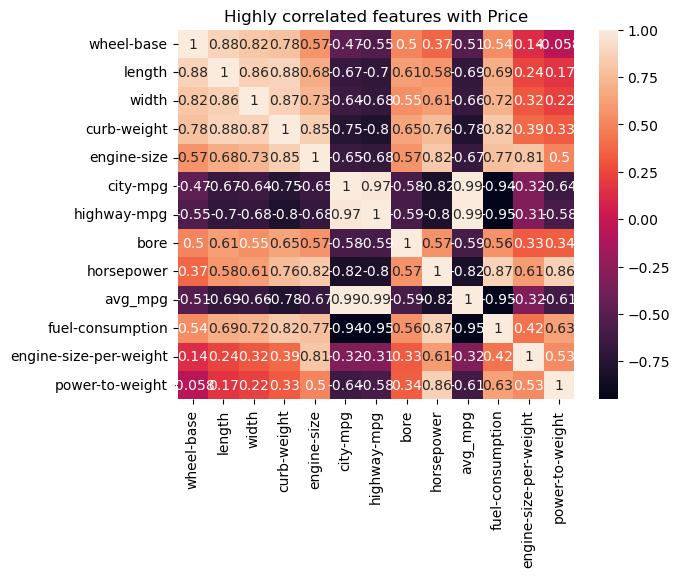

In [252]:
# Select highly correlated features with respect to dependent variable (Y)
# Correlation heatmap with respect to Price
high_corr_feature = []
target = 'price'

for col in df_merge_all.columns:
    if is_numeric_dtype(df_merge_all[col]):
            if col != target:
                high_corr_val = df_merge_all[target].corr(df_merge_all[col])
                if abs(high_corr_val) >= 0.5 and abs(high_corr_val) <= 1:
                    high_corr_feature.append(col)
                    
sns.heatmap(df_merge_all[high_corr_feature].corr(), annot=True)
plt.title('Highly correlated features with Price')

In [253]:
# Train Test Split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, 
                                                test_size=0.30, 
                                                random_state=2)


In [254]:
xTrain.shape

(141, 29)

In [255]:
# Select nummerical and categorical features for Data Preprocessing
number_array = np.array(X.select_dtypes(include=['int64', 'float64']).columns)
text_array = np.array(X.select_dtypes(include=['object']).columns)

In [256]:
# Apply ColumnTransformer to Scale and Encode the Numerical and Categorical fetures respectively
preprocess = ColumnTransformer([
    ('numer', StandardScaler(), number_array),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), text_array)
    ])

preprocess_transformed = preprocess.fit_transform(X)
print(preprocess_transformed)

[[ 1.72741085  0.         -1.68569083 ...  1.          0.
   0.        ]
 [ 1.72741085  0.         -1.68569083 ...  1.          0.
   0.        ]
 [ 0.13409125  0.         -0.71520325 ...  1.          0.
   0.        ]
 ...
 [-1.45922834 -0.84143038  1.68634227 ...  0.          0.
   0.        ]
 [-1.45922834 -0.84143038  1.68634227 ...  1.          0.
   0.        ]
 [-1.45922834 -0.84143038  1.68634227 ...  1.          0.
   0.        ]]


In [257]:
# Pipeline for KNN Regressor
pipeline_knn = Pipeline(steps=[
    ('preprocess', preprocess),
    ('knn_reg_model', KNeighborsRegressor(n_neighbors=5))
])

In [258]:
# Training with Train Data (KNN)
pipeline_knn.fit(xTrain, yTrain)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numer', StandardScaler(),
                                                  array(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'curb-weight', 'engine-size', 'compression-ratio',
       'city-mpg', 'highway-mpg', 'bore', 'stroke', 'horsepower',
       'peak-rpm', 'avg_mpg', 'fuel-consumption',
       'engine-size-per-weight', 'power-to-weight'], dtype=object)),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  array(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'engine-type',
       'num-of-cylinders', 'fuel-system'], dtype=object))])),
                ('knn_reg_model', KNeighborsRegressor())])

In [259]:
# Training R Square score for KNN
score_training_knn = pipeline_knn.score(xTrain, yTrain)
score_training_knn

0.8717258544668939

In [260]:
# Testing with Train Data (KNN)
pipeline_knn.fit(xTest, yTest)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numer', StandardScaler(),
                                                  array(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'curb-weight', 'engine-size', 'compression-ratio',
       'city-mpg', 'highway-mpg', 'bore', 'stroke', 'horsepower',
       'peak-rpm', 'avg_mpg', 'fuel-consumption',
       'engine-size-per-weight', 'power-to-weight'], dtype=object)),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  array(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'engine-type',
       'num-of-cylinders', 'fuel-system'], dtype=object))])),
                ('knn_reg_model', KNeighborsRegressor())])

In [261]:
# Testing R Square score for KNN
score_testing_knn = pipeline_knn.score(xTest, yTest)
score_testing_knn

0.8261263060239664

In [262]:
# Pipeline for Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocess', preprocess),
    ('linear_model', LinearRegression()),
])

In [263]:
# Training with Train Data (Lenear Regression)
pipeline_lr.fit(xTrain, yTrain)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numer', StandardScaler(),
                                                  array(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'curb-weight', 'engine-size', 'compression-ratio',
       'city-mpg', 'highway-mpg', 'bore', 'stroke', 'horsepower',
       'peak-rpm', 'avg_mpg', 'fuel-consumption',
       'engine-size-per-weight', 'power-to-weight'], dtype=object)),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  array(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'engine-type',
       'num-of-cylinders', 'fuel-system'], dtype=object))])),
                ('linear_model', LinearRegression())])

In [264]:
# Training R Square score for Linear Regression
score_training_lr = pipeline_lr.score(xTrain, yTrain)
score_training_lr

0.9843938167147503

In [265]:
# Testing with Train Data (Lenear Regression)
pipeline_lr.fit(xTest, yTest)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numer', StandardScaler(),
                                                  array(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'curb-weight', 'engine-size', 'compression-ratio',
       'city-mpg', 'highway-mpg', 'bore', 'stroke', 'horsepower',
       'peak-rpm', 'avg_mpg', 'fuel-consumption',
       'engine-size-per-weight', 'power-to-weight'], dtype=object)),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  array(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'engine-type',
       'num-of-cylinders', 'fuel-system'], dtype=object))])),
                ('linear_model', LinearRegression())])

In [266]:
# Testing R Square score for Linear Regression
score_test_lr = pipeline_lr.score(xTest, yTest)
score_test_lr

0.9988126914584368

In [267]:
# Predictions of Y
y_pred_lr = pipeline_lr.predict(xTrain)
y_pred_lr

array([ 7224.52264801, 13035.30195777, 14446.49995912, 16466.23912139,
       -1187.16626166,  7064.62542586,  9626.08640191,  1217.039944  ,
       34316.76399532, 24433.14580764, 17758.76586561, 14728.87448367,
       24433.14580764, 28817.21524392,  2453.96482327,  5653.83125229,
       68761.45278611,  4713.21212478,  5635.08527374, 12308.2320132 ,
       21183.04856566, 17879.63189691, 12766.0950623 , 11912.34173835,
       10466.17192892, 13011.19537017, 10679.34598352, 68761.45278611,
         451.96565331, -2914.0167088 ,  5633.13095012,  8325.56785317,
        2717.8138095 , -3882.62992295, 14311.13150962, 14368.12005971,
        5557.9032198 , 19185.76911297, 12317.23458793,  2596.22194298,
        8476.37295749,  8002.39142068, 13791.59471102, 15193.38076625,
        4622.78548044,  7824.60818678,  7042.57903847,  4826.88389366,
        8166.51940827, 10224.2474648 , 35451.63856735,  8444.60324102,
        7365.12703083, 17751.3507587 ,  8675.96869852, 14460.3787728 ,
      

In [268]:
# Model evaluation report 
print ("---Data Preprocessing---\n")
print(f'1. Features that reserve majority of Numerical Values (>95%) as \nString with missing values : {col_obj_to_num}\n')
print(f'2. Highly Correlated Features with respect to \nTarget Variable (Price), range within 0.5 to 1: \n{high_corr_feature}\n')

print(f'--- Model Evalution ---\n')
print(f'KNN Regression : \n')
print(f'3. Training Score (r²) for KNN Regression : {score_training_knn}')
print(f'4. Testing Score (r²) for KNN Regression : {score_testing_knn}\n')

print(f'Linear Regression : \n')
print(f'5. Training Score (r²) for Linear Regression : {score_training_lr}')
print(f'6. Testing Score (r²) for Linear Regression : {score_test_lr}\n')

print(f'--- Summary ---\n')
print(f'Based on the model evalution of both Linear Regression and KNN Regression, \nthe Learn Regression performed well in both Test and Train scenarios')


---Data Preprocessing---

1. Features that reserve majority of Numerical Values (>95%) as 
String with missing values : ['bore', 'stroke', 'horsepower', 'peak-rpm']

2. Highly Correlated Features with respect to 
Target Variable (Price), range within 0.5 to 1: 
['wheel-base', 'length', 'width', 'curb-weight', 'engine-size', 'city-mpg', 'highway-mpg', 'bore', 'horsepower', 'avg_mpg', 'fuel-consumption', 'engine-size-per-weight', 'power-to-weight']

--- Model Evalution ---

KNN Regression : 

3. Training Score (r²) for KNN Regression : 0.8717258544668939
4. Testing Score (r²) for KNN Regression : 0.8261263060239664

Linear Regression : 

5. Training Score (r²) for Linear Regression : 0.9843938167147503
6. Testing Score (r²) for Linear Regression : 0.9988126914584368

--- Summary ---

Based on the model evalution of both Linear Regression and KNN Regression, 
the Learn Regression performed well in both Test and Train scenarios
